In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from sklearn import svm, datasets
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [3]:
# import some data to play with
dataset = datasets.load_breast_cancer()
# Take the first two features. We could avoid this by using a two-dim dataset
X = dataset.data[:, :2]
y = dataset.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 2.0  # SVM regularization parameter
clf = svm.SVC(kernel='rbf', gamma=0.5, C=C)
clf.fit(X, y)

SVC(C=2.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [4]:
# Explicit prediction function, for reference
def predict_from_svm(clf, x):
    x = np.array(x)
    gamma = 1. / x.shape[1]
    kernel_features = rbf_kernel(clf.support_vectors_, x)
    return np.dot(clf.dual_coef_, kernel_features) + clf.intercept_

predict_from_svm(clf, [X[0]]), clf.decision_function([X[0]])

(array([[-1.0002894]]), array([-1.0002894]))

In [5]:
def _svm_rbf_l1_lower_bound(clf, point, radius):
    gamma = 1. / point.shape[0]
    score, = clf.decision_function([point])
    denom_upper_bound = np.linalg.norm(
        2 * gamma * np.dot(clf.dual_coef_, clf.support_vectors_ - point), 1)
    alpha = np.squeeze(clf.dual_coef_)
    denom_upper_bound += np.abs(2 * gamma) * np.dot(
        np.abs(alpha),
        radius * np.ones(alpha.shape))
    
    return np.abs(score) / denom_upper_bound

def svm_rbf_l1_lower_bound(clf, point,
                           max_radius=20,
                           grid_size=20000,
                           grid_breakpoint=1.0):
    rs = np.linspace(0, grid_breakpoint, grid_size // 2)
    rs = np.concatenate([rs, 
        np.linspace(grid_breakpoint, max_radius, grid_size // 2)])
    for r in reversed(rs):
        bound = _svm_rbf_l1_lower_bound(clf, point, r)
        if bound >= r:
            return r

In [6]:
bounds_20 = []
for x in tqdm.tqdm_notebook(X):
    bounds_20.append(svm_rbf_l1_lower_bound(clf, x, 20))
bounds_20 = np.array(bounds_20)

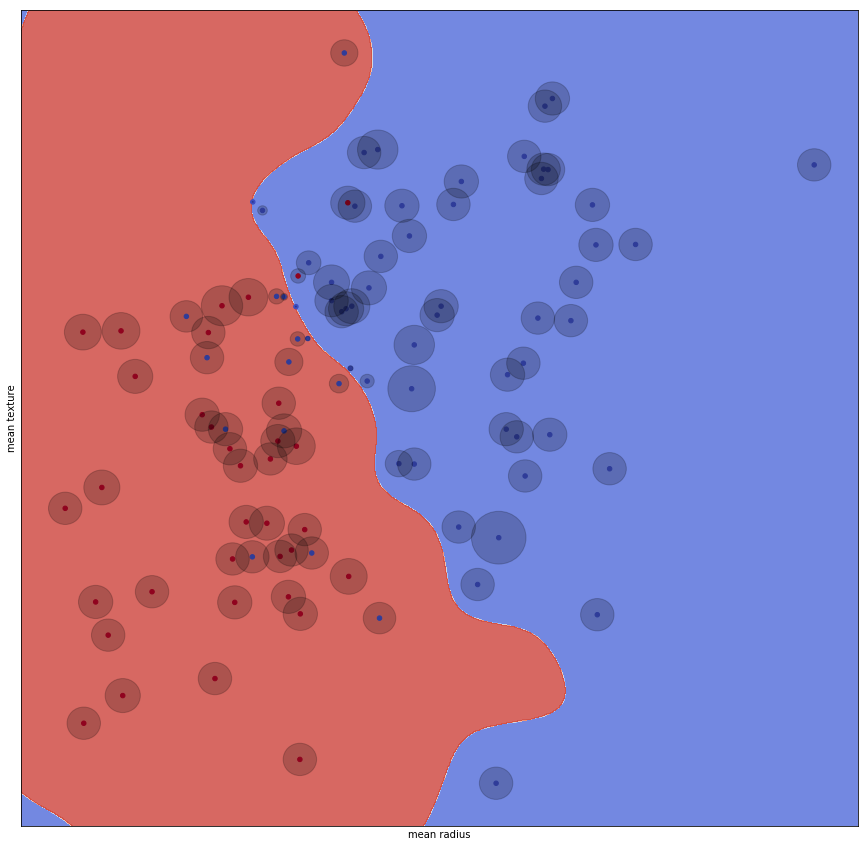

In [9]:
OFFSET = 0
NUM_POINTS = 100
start_range = OFFSET
end_range = OFFSET + NUM_POINTS

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(15)

plot_contours(ax, clf, xx, yy,
              cmap=plt.cm.coolwarm, alpha=0.8)
    
ax.scatter(X0[OFFSET:end_range],
           X1[OFFSET:end_range],
           c=y[OFFSET:end_range],
           cmap=plt.cm.coolwarm, s=20)

for i in range(OFFSET, end_range):
    ax.add_artist(
        plt.Circle((X0[i], X1[i]), 100 * bounds_20[i],
                   color='black', alpha=.2))

ax.set_xlim(X0[OFFSET:end_range].min() - 1,
            X0[OFFSET:end_range].max() + 1)
ax.set_ylim(X1[OFFSET:end_range].min() - 1,
            X1[OFFSET:end_range].max() + 1)
ax.set_xlabel(dataset.feature_names[0])
ax.set_ylabel(dataset.feature_names[1])

if NUM_POINTS < 20:
    for i in range(OFFSET, end_range):
        ax.annotate(str(i), (X0[i], X1[i]))

ax.set_xticks(())
ax.set_yticks(())

plt.show()